Описание задачи: классификация тональности текстов(3 класса) с использованием предобученной модели Bert на основе датасета твитов о фильме The Social Dilemma (https://www.kaggle.com/kaushiksuresh147/the-social-dilemma-tweets). Используются 2 метрики: f1 и accuracy. Есть простое решение в керасе без предобученных моделей с accuracy 0.9115: https://www.kaggle.com/ivxn99/simple-tensorflow2-keras-classification. 

In [ ]:
import math
import numpy as np
import pandas as pd
import os
import json
import collections
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertModel, BertForPreTraining


#Data

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
sd = pd.read_csv('/root/TheSocialDilemma.csv')  # https://www.kaggle.com/kaushiksuresh147/the-social-dilemma-tweets
sd = sd[['text', 'Sentiment']]
sd['Sentiment'] = sd['Sentiment'].map({'Negative':0, 'Neutral':1, 'Positive':2})

In [ ]:
#lengths = np.array([len(tokenizer(x)['input_ids']) for x in sd['text']])
#np.percentile(lengths, q=95)

In [ ]:
batch_size = 64
max_len = 52
validation_start_index = int(len(sd) * 0.1)

In [ ]:
class SDData(torch.utils.data.Dataset):

    def __init__(self, dataframe, tokenizer, max_len):

        self.data = dataframe
        self.tokenizer = tokenizer
        self.tweets = self.data.text
        self.targets = self.data.Sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        tweet = self.tweets[index]

        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens=True,
            padding='max_length',
            return_token_type_ids=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [ ]:
train_dataset = SDData(dataframe=sd[:-validation_start_index], max_len=max_len, 
                       tokenizer=tokenizer)
validation_dataset = SDData(dataframe=sd[-validation_start_index:].reset_index(drop=True), max_len=max_len,
                                       tokenizer=tokenizer)

len(train_dataset), len(validation_dataset)

(18062, 2006)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)

In [ ]:
for x in train_loader:
    break

In [ ]:
x

{'ids': tensor([[ 101, 1030, 2189,  ...,    0,    0,    0],
         [ 101, 1030, 2189,  ...,    0,    0,    0],
         [ 101, 2175, 3422,  ...,    0,    0,    0],
         ...,
         [ 101, 1000, 2566,  ...,    0,    0,    0],
         [ 101, 6203, 1030,  ...,    0,    0,    0],
         [ 101, 2033, 2321,  ...,    0,    0,    0]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'targets': tensor([1, 1, 2, 0, 2, 2, 1, 0, 2, 2, 2, 2, 2, 1, 0, 0, 2, 2, 2, 0, 2, 1, 1, 2,
         2, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 0, 1, 1, 2,
        

#train and evaluate functions

In [ ]:
def train(model, loader, criterion, optimizer, last_n_losses=500, verbose=True):
    
    losses = []
    f1_list = []
    acc_list = []

    progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Train')

    model.train()

    for x in loader:

        ids = x['ids'].cuda()
        mask = x['mask'].cuda()
        token_type_ids = x['token_type_ids'].cuda()
        y = x['targets'].cuda()

        pred = model(ids, mask, token_type_ids)

        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        preds = np.array([np.argmax(predd) for predd in pred.cpu().detach().numpy()])

        acc = accuracy_score(y.cpu(), preds)
        f1 = f1_score(y.cpu(), preds, average='micro')
        f1_list.append(f1)
        acc_list.append(acc)

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]))
        progress_bar.update()

    progress_bar.close()
    
    return losses, np.mean(f1_list), np.mean(acc_list)

In [ ]:
def evaluate(model, loader, criterion, last_n_losses=500, verbose=True):
    
    losses = []
    f1_list = []
    acc_list = []

    progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Evaluate')

    model.eval()

    for ids, mask, token_type_ids, y in loader:

        ids = x['ids'].cuda()
        mask = x['mask'].cuda()
        token_type_ids = x['token_type_ids'].cuda()
        y = x['targets'].cuda()

        with torch.no_grad():
            pred = model(ids, mask, token_type_ids)
        
        loss = criterion(pred, y)

        losses.append(loss.item())
        
        preds = np.array([np.argmax(predd) for predd in pred.cpu().detach().numpy()])

        acc = accuracy_score(y.cpu(), preds)
        f1 = f1_score(y.cpu(), preds, average='micro')
        f1_list.append(f1)
        acc_list.append(acc)

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]))
        progress_bar.update()

    progress_bar.close()
    
    return losses, np.mean(f1_list), np.mean(acc_list)

#BERT

In [ ]:
BERT = BertModel.from_pretrained("bert-base-uncased").cuda()
for par in BERT.parameters():
    par.requires_grad = False # иначе происходит CUDA out of memory

In [ ]:
class SDclassifier(torch.nn.Module):

    def __init__(self, model, hidden_size=768, output_size=3):
        super().__init__()
        self.encoder = model
        self.drop = torch.nn.Dropout(0.2)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, ids, mask, token_type_ids):
        _, x = self.encoder(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        x = self.drop(x)
        pred = self.linear(x)


        return pred

In [ ]:
model = SDclassifier(BERT)
model.cuda() 
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9,verbose=False)

In [ ]:
epochs = 10

train_losses = []
validation_losses = []

train_f1 = []
validation_f1 = []
train_acc = []
validation_acc = []

best_validation_acc = 999
best_validation_loss = 999

for n_epoch in range(1, epochs + 1):
    
    epoch_train_losses, epoch_train_f1, epoch_train_acc = train(model, train_loader, criterion, optimizer)
    scheduler.step()
    epoch_validation_losses, epoch_val_f1, epoch_val_acc = evaluate(model, validation_loader, criterion)
    mean_train_loss = np.mean(epoch_train_losses)
    mean_validation_loss = np.mean(epoch_validation_losses)
    
    train_losses.append(epoch_train_losses)
    train_f1.append(epoch_train_f1)
    train_acc.append(epoch_train_acc)
    
    validation_losses.append(epoch_validation_losses)
    validation_f1.append(epoch_val_f1)
    validation_acc.append(epoch_val_acc)
    
    message = f'Epoch: {n_epoch}\n'
    message += f'Train: loss - {mean_train_loss:.4f} | f1 - {train_f1[-1]:.3f} | acc - {train_acc[-1]:.3f}\n'
    message += f'Validation: loss - {mean_validation_loss:.4f} | f1 - {validation_f1[-1]:.3f}| acc - {validation_acc[-1]:.3f}'
    
    print(message)
    
    if mean_validation_loss < best_validation_loss:
        
        best_validation_loss = mean_validation_loss
        
        torch.save(model.state_dict(), f'best_language_model_state_dict.pth')
        torch.save(optimizer.state_dict(), 'best_optimizer_state_dict.pth')
        
    torch.save(model.state_dict(), f'last_language_model_state_dict.pth')
    torch.save(optimizer.state_dict(), 'last_optimizer_state_dict.pth')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':



Epoch: 1
Train: loss - 1.0348 | f1 - 0.478 | acc - 0.478
Validation: loss - 0.9897 | f1 - 0.539| acc - 0.539



Epoch: 2
Train: loss - 1.0138 | f1 - 0.502 | acc - 0.502
Validation: loss - 0.9778 | f1 - 0.566| acc - 0.566



Epoch: 3
Train: loss - 1.0041 | f1 - 0.506 | acc - 0.506
Validation: loss - 0.9684 | f1 - 0.562| acc - 0.562



Epoch: 4
Train: loss - 0.9963 | f1 - 0.519 | acc - 0.519
Validation: loss - 0.9607 | f1 - 0.547| acc - 0.547



Epoch: 5
Train: loss - 0.9920 | f1 - 0.523 | acc - 0.523
Validation: loss - 0.9560 | f1 - 0.547| acc - 0.547



Epoch: 6
Train: loss - 0.9884 | f1 - 0.526 | acc - 0.526
Validation: loss - 0.9520 | f1 - 0.539| acc - 0.539



Epoch: 7
Train: loss - 0.9826 | f1 - 0.529 | acc - 0.529
Validation: loss - 0.9501 | f1 - 0.539| acc - 0.539



Epoch: 8
Train: loss - 0.9787 | f1 - 0.532 | acc - 0.532
Validation: loss - 0.9479 | f1 - 0.559| acc - 0.559



Epoch: 9
Train: loss - 0.9769 | f1 - 0.532 | acc - 0.532
Validation: loss - 0.9453 | f1 - 0.543| acc - 0.543



Epoch: 10
Train: loss - 0.9735 | f1 - 0.534 | acc - 0.534
Validation: loss - 0.9444 | f1 - 0.551| acc - 0.551


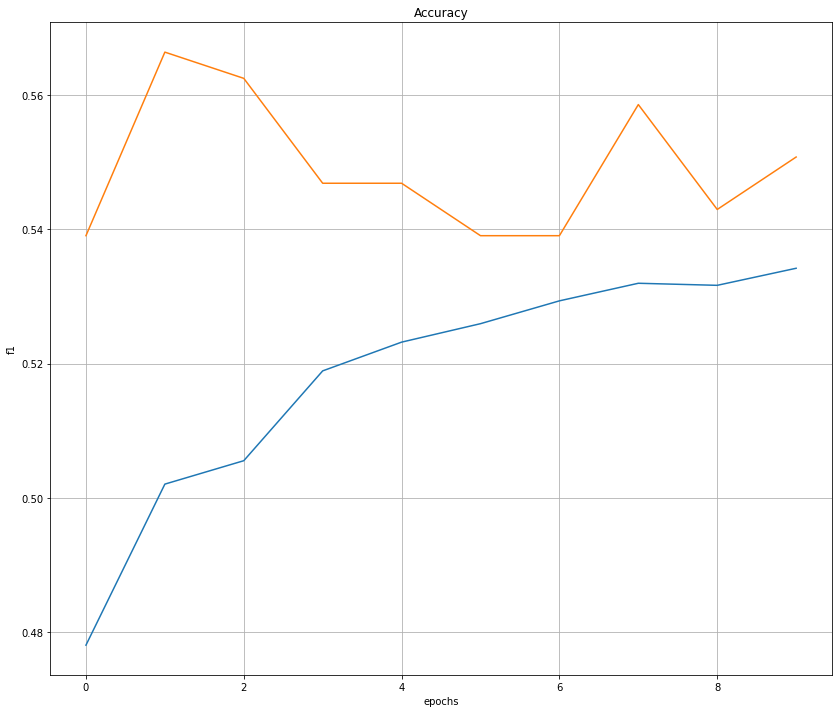

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(train_acc)
plt.plot(validation_acc)
plt.grid()
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('f1');

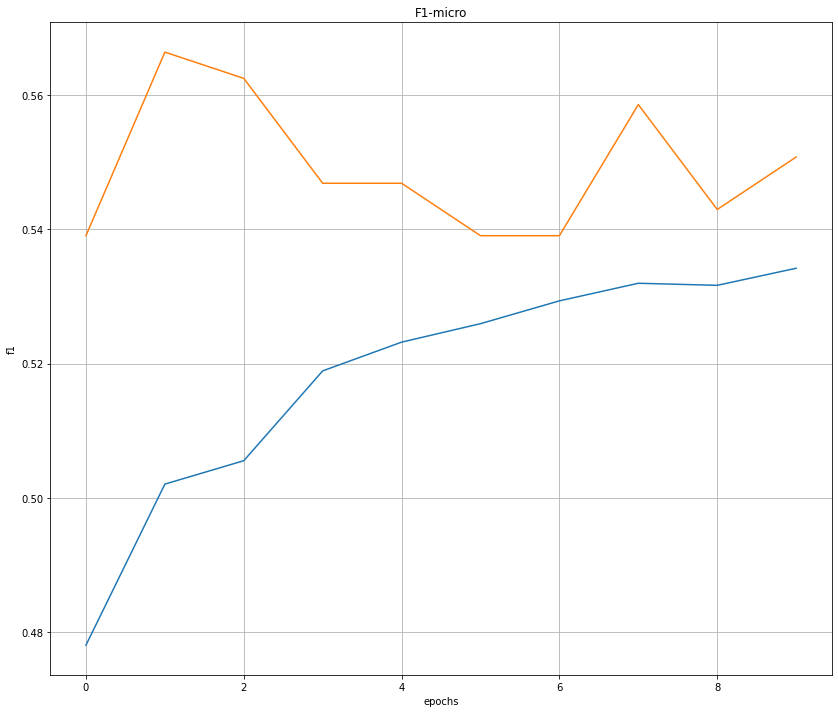

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(train_f1)
plt.plot(validation_f1)
plt.grid()
plt.title('F1-micro')
plt.xlabel('epochs')
plt.ylabel('f1');

#Попытка 2

In [ ]:
model = SDclassifier(BERT)
model.cuda() 
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.005) # lr: 0.001->0.005
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99,verbose=False) # gamma: 0.9->0.99

In [ ]:
epochs = 15 # 10 -> 15

train_losses = []
validation_losses = []

train_f1 = []
validation_f1 = []
train_acc = []
validation_acc = []

best_validation_acc = 999
best_validation_loss = 999

for n_epoch in range(1, epochs + 1):
    
    epoch_train_losses, epoch_train_f1, epoch_train_acc = train(model, train_loader, criterion, optimizer)
    scheduler.step()
    epoch_validation_losses, epoch_val_f1, epoch_val_acc = evaluate(model, validation_loader, criterion)
    mean_train_loss = np.mean(epoch_train_losses)
    mean_validation_loss = np.mean(epoch_validation_losses)
    
    train_losses.append(epoch_train_losses)
    train_f1.append(epoch_train_f1)
    train_acc.append(epoch_train_acc)
    
    validation_losses.append(epoch_validation_losses)
    validation_f1.append(epoch_val_f1)
    validation_acc.append(epoch_val_acc)
    
    message = f'Epoch: {n_epoch}\n'
    message += f'Train: loss - {mean_train_loss:.4f} | f1 - {train_f1[-1]:.3f} | acc - {train_acc[-1]:.3f}\n'
    message += f'Validation: loss - {mean_validation_loss:.4f} | f1 - {validation_f1[-1]:.3f}| acc - {validation_acc[-1]:.3f}'
    
    print(message)
    
    if mean_validation_loss < best_validation_loss:
        
        best_validation_loss = mean_validation_loss
        
        torch.save(model.state_dict(), f'best_language_model_state_dict.pth')
        torch.save(optimizer.state_dict(), 'best_optimizer_state_dict.pth')
        
    torch.save(model.state_dict(), f'last_language_model_state_dict.pth')
    torch.save(optimizer.state_dict(), 'last_optimizer_state_dict.pth')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Epoch: 1
Train: loss - 1.0494 | f1 - 0.485 | acc - 0.485
Validation: loss - 0.9983 | f1 - 0.609| acc - 0.609



Epoch: 2
Train: loss - 1.0233 | f1 - 0.508 | acc - 0.508
Validation: loss - 1.0314 | f1 - 0.469| acc - 0.469



Epoch: 3
Train: loss - 1.0161 | f1 - 0.511 | acc - 0.511
Validation: loss - 0.9497 | f1 - 0.594| acc - 0.594



Epoch: 4
Train: loss - 1.0160 | f1 - 0.511 | acc - 0.511
Validation: loss - 0.9351 | f1 - 0.547| acc - 0.547



Epoch: 5
Train: loss - 1.0228 | f1 - 0.511 | acc - 0.511
Validation: loss - 0.9133 | f1 - 0.609| acc - 0.609



Epoch: 6
Train: loss - 1.0060 | f1 - 0.522 | acc - 0.522
Validation: loss - 0.9479 | f1 - 0.547| acc - 0.547



Epoch: 7
Train: loss - 1.0100 | f1 - 0.516 | acc - 0.516
Validation: loss - 0.9036 | f1 - 0.562| acc - 0.562



Epoch: 8
Train: loss - 1.0124 | f1 - 0.514 | acc - 0.514
Validation: loss - 0.9196 | f1 - 0.562| acc - 0.562



Epoch: 9
Train: loss - 1.0129 | f1 - 0.519 | acc - 0.519
Validation: loss - 0.9040 | f1 - 0.547| acc - 0.547



Epoch: 10
Train: loss - 1.0052 | f1 - 0.523 | acc - 0.523
Validation: loss - 0.9076 | f1 - 0.578| acc - 0.578



Epoch: 11
Train: loss - 1.0002 | f1 - 0.521 | acc - 0.521
Validation: loss - 0.9184 | f1 - 0.484| acc - 0.484



Epoch: 12
Train: loss - 1.0023 | f1 - 0.522 | acc - 0.522
Validation: loss - 0.9195 | f1 - 0.609| acc - 0.609



Epoch: 13
Train: loss - 1.0129 | f1 - 0.516 | acc - 0.516
Validation: loss - 0.9324 | f1 - 0.516| acc - 0.516



Epoch: 14
Train: loss - 1.0068 | f1 - 0.520 | acc - 0.520
Validation: loss - 0.9195 | f1 - 0.500| acc - 0.500



Epoch: 15
Train: loss - 1.0047 | f1 - 0.523 | acc - 0.523
Validation: loss - 0.9052 | f1 - 0.531| acc - 0.531


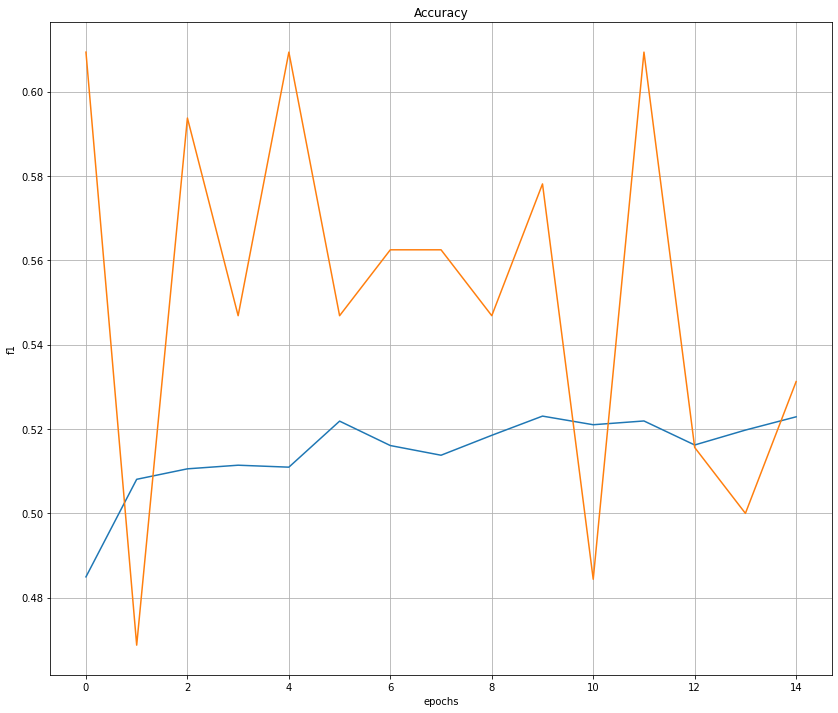

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(train_acc)
plt.plot(validation_acc)
plt.grid()
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('f1');

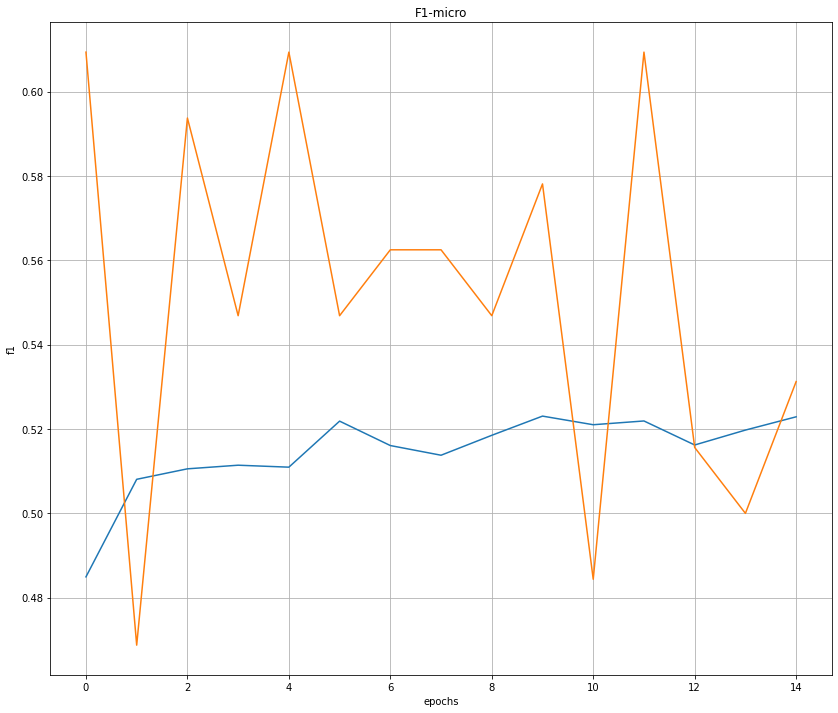

In [ ]:
plt.figure(figsize=(14, 12))
plt.plot(train_f1)
plt.plot(validation_f1)
plt.grid()
plt.title('F1-micro')
plt.xlabel('epochs')
plt.ylabel('f1');

#Попытка 3

In [ ]:
model = SDclassifier(BERT)
model.cuda() 
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.015) # ->0.015
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9,verbose=False) 

In [ ]:
epochs = 15

train_losses = []
validation_losses = []

train_f1 = []
validation_f1 = []
train_acc = []
validation_acc = []

best_validation_loss = 999

for n_epoch in range(1, epochs + 1):
    
    epoch_train_losses, epoch_train_f1, epoch_train_acc = train(model, train_loader, criterion, optimizer)
    epoch_validation_losses, epoch_val_f1, epoch_val_acc = evaluate(model, validation_loader, criterion)
    mean_train_loss = np.mean(epoch_train_losses)
    mean_validation_loss = np.mean(epoch_validation_losses)
    
    train_losses.append(epoch_train_losses)
    train_f1.append(epoch_train_f1)
    train_acc.append(epoch_train_acc)
    
    validation_losses.append(epoch_validation_losses)
    validation_f1.append(epoch_val_f1)
    validation_acc.append(epoch_val_acc)
    
    message = f'Epoch: {n_epoch}\n'
    message += f'Train: loss - {mean_train_loss:.4f} | f1 - {train_f1[-1]:.3f} | acc - {train_acc[-1]:.3f}\n'
    message += f'Validation: loss - {mean_validation_loss:.4f} | f1 - {validation_f1[-1]:.3f}| acc - {validation_acc[-1]:.3f}'
    
    print(message)
    
    if mean_validation_loss < best_validation_loss:
        
        best_validation_loss = mean_validation_loss
        
        torch.save(model.state_dict(), f'best_language_model_state_dict.pth')
        torch.save(optimizer.state_dict(), 'best_optimizer_state_dict.pth')
        
    elif mean_validation_loss > best_validation_loss:
        break
        
    torch.save(model.state_dict(), f'last_language_model_state_dict.pth')
    torch.save(optimizer.state_dict(), 'last_optimizer_state_dict.pth')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



Epoch: 1
Train: loss - 1.1639 | f1 - 0.465 | acc - 0.465
Validation: loss - 0.9449 | f1 - 0.578| acc - 0.578



Epoch: 2
Train: loss - 1.1413 | f1 - 0.474 | acc - 0.474
Validation: loss - 0.9913 | f1 - 0.578| acc - 0.578


Трудности при обучении:
1) Долго не понимал, как реализуется transfer learning в коде
2) Ограничения по использованию GPU в колабе (в итоге перешел на vast.ai)
3) Результаты неоднозначные. Accuracy чуть более 60 для 3 классов с одной стороны неплохо, но с другой стороны видел тетрадку с простой реализацией в керасе https://www.kaggle.com/ivxn99/simple-tensorflow2-keras-classification , где получался accuracy на уровне 0.9115. Однако здесь много оговорок (токенизация, очистка данных, более простая модель и т.д.). 
4) Не сильно вникал, как происходит токенизация в предобученной модели. Пытался очистить данные перед токенизацией, но всё получалось значительно хуже (accuracy падало до 0.3-0.4)
5) С обновлением весов у Берта GPU не справлялся. Возможно, при их обновлении всё могло бы получиться гораздо лучше.